# EOSC 573 - Final Project - analysis of CTD Data + drifter tracks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from matplotlib import cm
import math

import scipy.interpolate 
from scipy.interpolate import griddata, interpn
import scipy.io as spio
import gsw

from datetime import datetime

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [3]:
df = pd.read_csv('CTDcrosssection.csv',index_col=0)
df = df.sort_values(by=['transect', 'station','pressure'],ignore_index=True)

In [4]:
#lets add a density column
df['density']=gsw.density.rho_t_exact(df.salinity, df.temperature, df.pressure)
df

,transect,station,lat,lon,depth,temperature,salinity,pressure,seadepth,density
0,T1,S1,49.3163,-123.1365,19.7,7.542696,27.461443,0.75,0.576803,1021.322756
1,T1,S1,49.3163,-123.1365,19.7,7.571068,27.662969,1.25,1.336883,1021.478877
2,T1,S1,49.3163,-123.1365,19.7,7.578932,27.692867,1.75,1.707430,1021.503541
3,T1,S1,49.3163,-123.1365,19.7,7.581245,27.781558,2.25,2.190382,1021.574832
4,T1,S1,49.3163,-123.1365,19.7,7.593192,27.858558,2.75,2.686998,1021.635757
...,...,...,...,...,...,...,...,...,...,...
1712,T6,S5,49.3122,-123.1721,28.9,8.223764,29.298585,24.75,24.574700,1022.776695
1713,T6,S5,49.3122,-123.1721,28.9,8.234730,29.318648,25.25,25.074019,1022.793110
1714,T6,S5,49.3122,-123.1721,28.9,8.242642,29.322720,25.75,25.561849,1022.797482
1715,T6,S5,49.3122,-123.1721,28.9,8.243155,29.333838,26.25,26.028045,1022.808378


### TS Plot

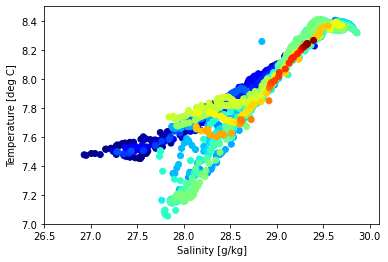

In [5]:
#scatter plot collower by 2D histogram
fig , ax = plt.subplots()
data , x_e, y_e = np.histogram2d( df.salinity,df.temperature, bins = 20, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([df.salinity,df.temperature]).T , method = "splinef2d", bounds_error = False)

z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
df.salinity, df.temperature, z = df.salinity[idx], df.temperature[idx], z[idx]

plt.scatter( df.salinity, df.temperature, c=z, cmap='jet')

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
#cbar.ax.set_ylabel('Density')
plt.xlabel('Salinity [g/kg]')
plt.ylabel('Temperature [deg C]')

# plt.plot([27.9,27.9],[7.65,7],'k--')
# plt.plot([27.9,26.5],[7.65,7.65],'k--')
# plt.plot([26.9,26.9],[7.47,7],'k--')
# plt.plot([26.9,26.5],[7.47,7.47],'k--')

plt.ylim([7,8.5])
plt.xlim([26.5,30.1])

plt.savefig('TSplot.png')

In [6]:
gsw.density.rho_t_exact(27.9, 7.65, 10)

1021.694354622229

### Temperature and Salinity Profiles

In [7]:
Dmin = 1020.9
Dmax = 1023.4
levels = np.linspace(Dmin,Dmax, 21)

#### Transect 1

In [8]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T1']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T1']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T1']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T1']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T1']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T1']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T1']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T1']))

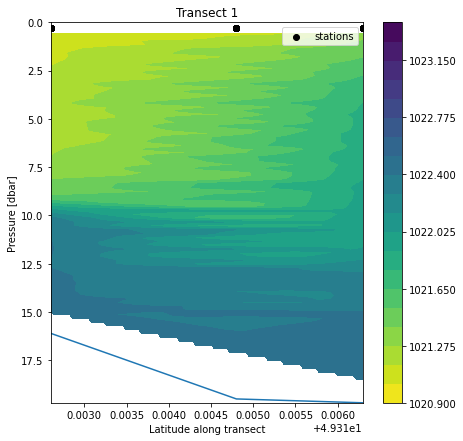

In [9]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

# #SALINITY
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), salinity, (xi[None, :], yi[:, None]), method='linear')

# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('SALINITY\nTransect 5')

# #TEMPERATURE
# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((lat, seadepth), temperature, (xi[None, :], yi[:, None]), method='linear')

# plt.subplot(1,2,2)
# plt.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
# plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
# plt.colorbar()
# #depth
# plt.plot(bottomlat, bottomdepth)
# plt.axis([min(lat),max(lat),max(bottomdepth),0])
# plt.title('TEMPERATURE\nTransect 5')

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
# plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
plt.scatter(lat,top, c='k', label='stations')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.title('Transect 1')
plt.legend()

plt.savefig('rho_tr1.png')

#### Transect 2

In [10]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T2']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T2']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T2']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T2']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T2']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T2']
print(len(top))

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T2']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T2']))

286


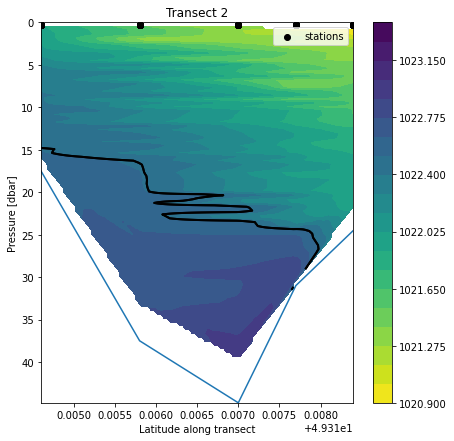

In [11]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)


#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('Transect 2')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

plt.savefig('rho_tr2.png')

#### Transect 3

In [12]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T3']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T3']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T3']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T3']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T3']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T3']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T3']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T3']))

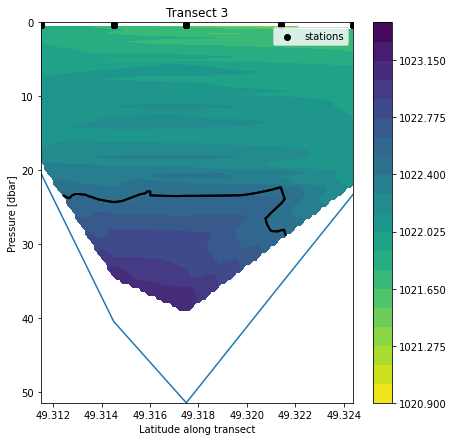

In [13]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('Transect 3')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

plt.savefig('rho_tr3.png')

#### Transect 4

In [14]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T4']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T4']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T4']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T4']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T4']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T4']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T4']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T4']))

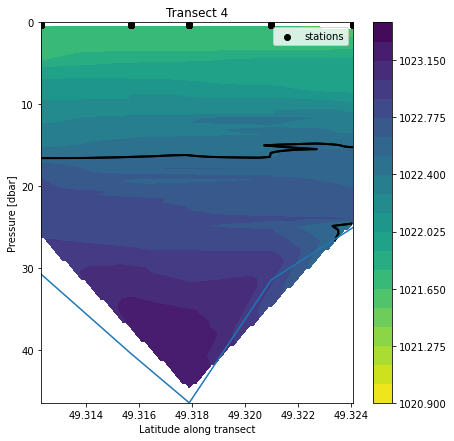

In [15]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('Transect 4')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

plt.savefig('rho_tr4.png')

#### Transect 6

In [16]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T6']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T6']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T6']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T6']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T6']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T6']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T6']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T6']))

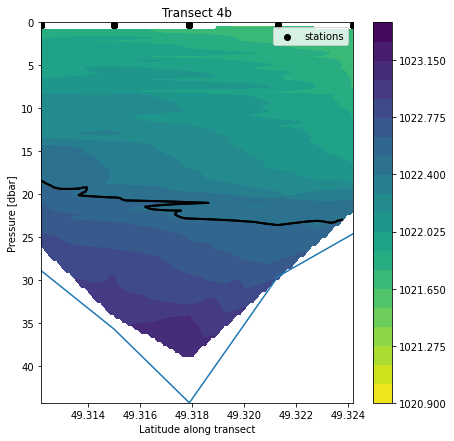

In [17]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('Transect 4b')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

plt.savefig('rho_tr6.png')

#### Transect 5

In [18]:
salinity = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T5']
temperature = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T5']
density = [df.density[i] for i in range(len(df)) if df.transect[i]=='T5']
seadepth = [df.seadepth[i] for i in range(len(df)) if df.transect[i]=='T5']
lat = [df.lat[i] for i in range(len(df)) if df.transect[i]=='T5']
top = [0.3 for i in range(len(df)) if df.transect[i]=='T5']

bottomdepth = list(dict.fromkeys([df.depth[i] for i in range(len(df)) if df.transect[i]=='T5']))
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T5']))

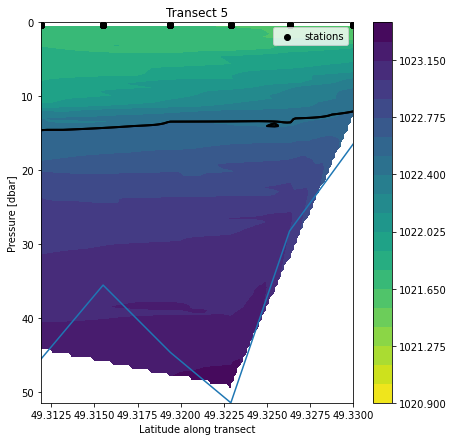

In [19]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(lat),max(lat), ngridx)
yi = np.linspace(0, max(bottomdepth), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((lat, seadepth), density, (xi[None, :], yi[:, None]), method='linear')

plt.figure(figsize=(7,7))
plt.contour(xi, yi, zi, [1022.51,1022.5101], linewidths=2, colors='k')
# plt.contour(xi, yi, zi, levels, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, levels, cmap="viridis_r")
plt.colorbar()
#depth
plt.plot(bottomlat, bottomdepth)
plt.axis([min(lat),max(lat),max(bottomdepth),0])
plt.title('Transect 5')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Latitude along transect')
plt.scatter(lat,top, c='k', label='stations')
plt.legend()

plt.savefig('rho_tr5.png')

### Stability
Calulating N2 as another good measure of exent of jet

In [20]:
#calc seperately for each profile as p must be increasing for gsw to calc it

kk = [1,2,3,4,5,6] #transect number
nSt = [3,5,5,5,6,5] #number of station in each transect
N2 = []
p_mid = []
N2_tran = []
N2_sta = []
N2_lat = []
length = 0

for k in kk:
    for l in range(nSt[k-1]):
        S = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        T = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        P = [df.pressure[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        CT = gsw.CT_from_t(S, T, P)
        N2_tran += list(np.full(len(P)-1,k))
        N2_sta += list(np.full(len(P)-1,l+1))
        N2_lat += list(np.full(len(P)-1,df.lat[length+1]))
        length += len(P)
        
        N2 += list(gsw.stability.Nsquared(S, CT, P)[0])
        p_mid += list(gsw.stability.Nsquared(S, CT, P)[1])

In [21]:
# wowee ANOTHER dataframe
N2data = pd.DataFrame({'transect': N2_tran,
         'station': N2_sta,     
         'lat': N2_lat,
        'p_mid':p_mid,
         'N2': N2})
N2data

,transect,station,lat,p_mid,N2
0,1,1,49.3163,1.0,0.002952
1,1,1,49.3163,1.5,0.000429
2,1,1,49.3163,2.0,0.001324
3,1,1,49.3163,2.5,0.001125
4,1,1,49.3163,3.0,0.001473
...,...,...,...,...,...
1683,6,5,49.3122,24.5,0.000258
1684,6,5,49.3122,25.0,0.000271
1685,6,5,49.3122,25.5,0.000040
1686,6,5,49.3122,26.0,0.000165


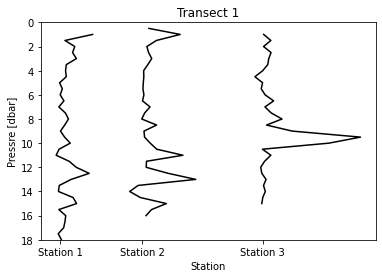

In [22]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T1']))
space = [(bottomlat[i]-bottomlat[0])*(-5) for i in range(len(bottomlat))]

fig = plt.figure()
# ax = fig.add_subplot(111)

for i in range(nSt[0]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==1 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==1 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3'])
    plt.title('Transect 1')
    plt.ylabel('Pressre [dbar]')
    plt.xlabel('Station')
    plt.ylim([18,0])

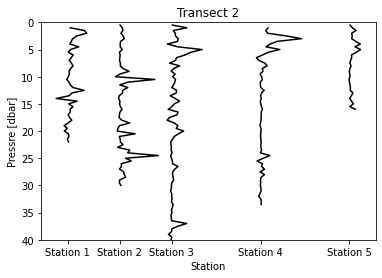

In [23]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T2']))
space = [(bottomlat[i]-bottomlat[0])*(-10) for i in range(len(bottomlat))]

fig = plt.figure()

for i in range(nSt[1]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==2 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==2 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5'])
    plt.title('Transect 2')
    plt.ylabel('Pressre [dbar]')
    plt.xlabel('Station')
    plt.ylim([40,0])

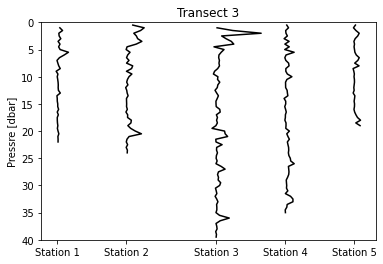

In [24]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T3']))
space = [(bottomlat[i]-bottomlat[0])*(-3) for i in range(len(bottomlat))]

fig = plt.figure()

for i in range(nSt[2]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==3 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==3 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5'])
    plt.title('Transect 3')
    plt.ylabel('Pressre [dbar]')
    plt.ylim([40,0])

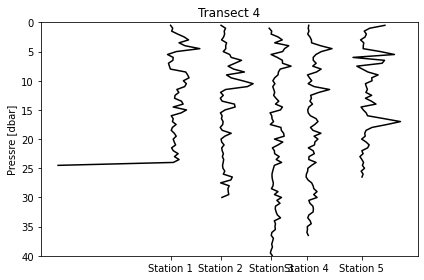

In [25]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T4']))
space = [(bottomlat[i]-bottomlat[0])*(-1) for i in range(len(bottomlat))]

fig = plt.figure()
# ax = fig.add_subplot(111)

for i in range(nSt[3]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==4 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==4 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5'])
    plt.title('Transect 4')
    plt.ylabel('Pressre [dbar]')
    plt.ylim([40,0])
    
plt.tight_layout()

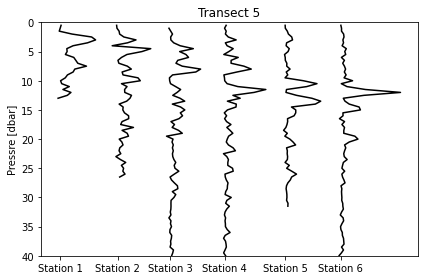

In [26]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T5']))
space = [(bottomlat[i]-bottomlat[0])*(-1) for i in range(len(bottomlat))]

fig = plt.figure()
# ax = fig.add_subplot(111)

for i in range(nSt[4]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==5 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==5 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5', 'Station 6'])
    plt.title('Transect 5')
    plt.ylabel('Pressre [dbar]')
    plt.ylim([40,0])
    
plt.tight_layout()

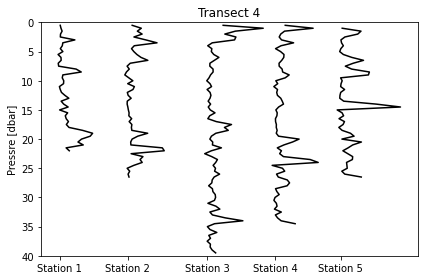

In [27]:
bottomlat = list(dict.fromkeys([df.lat[i] for i in range(len(df)) if df.transect[i]=='T6']))
space = [(bottomlat[i]-bottomlat[0])*(-1) for i in range(len(bottomlat))]

fig = plt.figure()
# ax = fig.add_subplot(111)

for i in range(nSt[5]):
    N2 = [N2data.N2[j] + space[i] for j in range(len(N2data)) if N2data.transect[j]==6 and N2data.station[j]==i+1]
    pressure = [N2data.p_mid[j] for j in range(len(N2data)) if N2data.transect[j]==6 and N2data.station[j]==i+1]
    plt.plot(N2,pressure,'k')
    plt.xticks(space, labels=['Station 1', 'Station 2', 'Station 3', 'Station 4', 'Station 5'])
    plt.title('Transect 4')
    plt.ylabel('Pressre [dbar]')
    plt.ylim([40,0])
    
plt.tight_layout()

### Drifters

In [28]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [29]:
drift = loadmat('/ocean/kstankov/driftersL1L2L3/L2/drifters_L2_32_Burrard.mat')['drift']
drift[0]._fieldnames

['id', 'deviceid', 'design', 'tzone', 'mtime', 'lon', 'lat', 'UTCtime']

In [30]:
drift[0].lat = drift[0].lat[1:-1]
drift[0].lon = drift[0].lon[1:-1]
drift[1].lat = drift[1].lat[10:]
drift[1].lon = drift[1].lon[10:]                
drift[2].lat = drift[2].lat[1:]
drift[2].lon = drift[2].lon[1:]

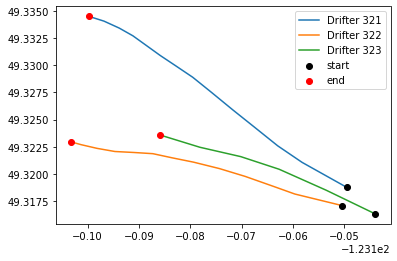

In [31]:
plt.plot(drift[2].lon,drift[2].lat,label='Drifter '+str(drift[2].id),zorder=1)
plt.plot(drift[0].lon,drift[0].lat,label='Drifter '+str(drift[0].id),zorder=1)
plt.plot(drift[1].lon,drift[1].lat,label='Drifter '+str(drift[1].id),zorder=1)
plt.scatter([drift[2].lon[0],drift[0].lon[0],drift[1].lon[0]],[drift[2].lat[0],drift[0].lat[0],drift[1].lat[0]],c='k', label='start',zorder=2)
plt.scatter([drift[2].lon[-1],drift[0].lon[-1],drift[1].lon[-1]],[drift[2].lat[-1],drift[0].lat[-1],drift[1].lat[-1]],c='r', label='end',zorder=2)
plt.legend()

In [33]:
#make function to convert between diff in lat lon to m
def latlon_m(lat1,lat2,lon1,lon2):
    # approximate radius of earth in km
    R = 6373.0
    
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180;
    dLon = lat2 * math.pi / 180 - lat1 * math.pi / 180;

    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) *math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c *1000
    
    return distance

In [34]:
speed321 = [latlon_m(drift[2].lat[i],drift[2].lat[i+1],drift[2].lon[i],drift[2].lon[i])/(10*60) for i in range(len(drift[2].lat)-1)]
speed322 = [latlon_m(drift[0].lat[i],drift[0].lat[i+1],drift[0].lon[i],drift[0].lon[i])/(10*60) for i in range(len(drift[0].lat)-1)]
speed323 = [latlon_m(drift[1].lat[i],drift[1].lat[i+1],drift[1].lon[i],drift[1].lon[i])/(10*60) for i in range(len(drift[1].lat)-1)]

In [35]:
time321 = pd.date_range(start='2021-02-19 11:50', periods=13, freq='10min')
time322 = pd.date_range(start='2021-02-19 12:00', periods=12, freq='10min')
time323 = pd.date_range(start='2021-02-19 13:30', periods=5, freq='10min')

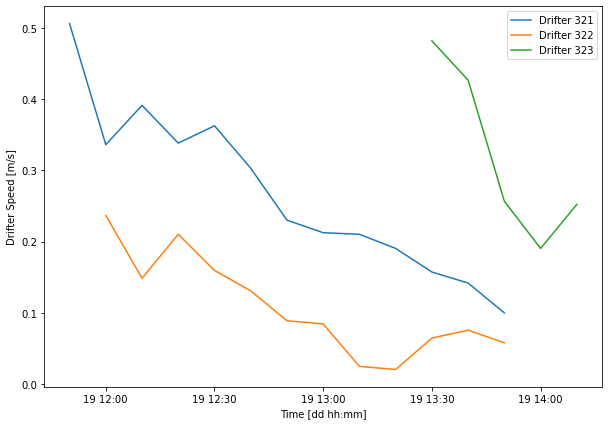

In [36]:
plt.figure(figsize=(10,7))
plt.plot(time321,speed321,label= "Drifter 321")
plt.plot(time322,speed322,label= "Drifter 322")
plt.plot(time323,speed323,label= "Drifter 323")
plt.legend()
plt.ylabel('Drifter Speed [m/s]')
plt.xlabel('Time [dd hh:mm]')

plt.savefig('DrifterSpeed.png')

### Geostrophy Calcs - depth of 0.75 dB
calc the velocity AND dynamic height at the surface and show taht plot - def <br>
calc velocity at eery depth and show cross sections - maybe

In [37]:
#calc dynamic height seperately for each profile as p must be increasing for gsw to calc it

kk = [1,2,3,4,5,6] #transect number
nSt = [3,5,5,5,6,5] #number of station in each transect
stream = []
a=[]

for k in kk:
    for l in range(nSt[k-1]):
        S = [df.salinity[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        T = [df.temperature[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        P = [df.pressure[i] for i in range(len(df)) if df.transect[i]=='T'+str(k) and df.station[i]=='S'+str(l+1)]
        CT = gsw.CT_from_t(S, T, P)
        
        refP = 10 #15 m reference depth
        a +=list(P)
        stream += list(gsw.geostrophy.geo_strf_dyn_height(S, CT, P, p_ref=refP, axis=0, max_dp=1.0))
#lets add a dynamic height column
df['Stream Function']=stream
df;

In [38]:
#create a new data frame with ONLY info from a depth of 0.75 dB
surface = pd.DataFrame({'transect': [df.transect[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'station': [df.station[i] for i in range(len(df)) if df.pressure[i]==0.75], 
         'lat': [df.lat[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'lon': [df.lon[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'depth': [df.depth[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'temperature': [df.temperature[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'salinity': [df.salinity[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'pressure':[df.pressure[i] for i in range(len(df)) if df.pressure[i]==0.75],
         'stream':[df['Stream Function'][i] for i in range(len(df)) if df.pressure[i]==0.75],
         'seadepth': [df.seadepth[i] for i in range(len(df)) if df.pressure[i]==0.75]})
surface;

In [39]:
burrard = loadmat('PNW.mat')

x= burrard['ncst'][:,0]
y= burrard['ncst'][:,1]

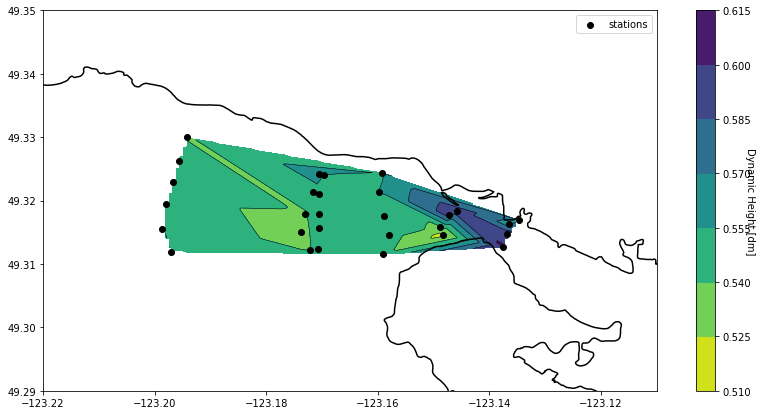

In [40]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(surface.lon),max(surface.lon), ngridx)
yi = np.linspace(min(surface.lat),max(surface.lat), ngridy)

#DENSITY
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
#zi = griddata((surface.lon[:24], surface.lat[:24]), surface.stream[:24], (xi[None, :], yi[:, None]), method='linear')
zi = griddata((surface.lon, surface.lat), surface.stream, (xi[None, :], yi[:, None]), method='linear')

fig, ax = plt.subplots(figsize=(14, 7))
plt.contour(xi, yi, zi, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, cmap="viridis_r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Dynamic Height [dm]', rotation=270)

plt.xlim([-123.22, -123.11])
plt.ylim([49.29,49.35])
#plt.title('DENSITY\nTransect 4')

ax.plot(x, y, 'k')
ax.scatter(surface.lon, surface.lat, c='k', label='stations')
ax.set_aspect(5/4.4)
ax.legend()

plt.savefig('DynamicHeight.png')

In [41]:
## what if we did the same thing but only for the top 15 m
#create a new data frame with ONLY info from a depth of 0.75 dB to 15.25 db
Ps = np.arange(0.75,13.75,0.5)
top13 = pd.DataFrame({'transect': [df.transect[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'station': [df.station[i] for i in range(len(df)) if df.pressure[i] in Ps], 
         'lat': [df.lat[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'lon': [df.lon[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'depth': [df.depth[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'temperature': [df.temperature[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'salinity': [df.salinity[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'pressure':[df.pressure[i] for i in range(len(df)) if df.pressure[i] in Ps],
         'stream':[df['Stream Function'][i] for i in range(len(df)) if df.pressure[i] in Ps],
         'seadepth': [df.seadepth[i] for i in range(len(df)) if df.pressure[i] in Ps]})
top13;

In [42]:
DH = np.zeros([29,len(Ps)])

k=0
for i in range(29):
    for j in range(len(Ps)):
        DH[i,j] = top13.stream[k]
        k+=1
        
DH1 = DH[:sum(nSt[:1]),:]
DH2 = DH[nSt[0]:sum(nSt[:2]),:]
DH3 = DH[sum(nSt[:2]):sum(nSt[:3]),:]
DH4 = DH[sum(nSt[:3]):sum(nSt[:4]),:]
DH5 = DH[sum(nSt[:4]):sum(nSt[:5]),:]
DH6 = DH[sum(nSt[:5]):,:]

In [43]:
#the velocity result is perpendicular the the line connecting two points 
#SO in order to make it easily understandable in a figure the velocity of each transect much be done seperately

V1 = gsw.geostrophy.geostrophic_velocity(DH1.T,surface.lon.to_numpy()[:sum(nSt[:1])], surface.lat.to_numpy()[:sum(nSt[:1])], Ps.reshape(26,1), axis=0)
V2 = gsw.geostrophy.geostrophic_velocity(DH2.T,surface.lon.to_numpy()[nSt[0]:sum(nSt[:2])], surface.lat.to_numpy()[nSt[0]:sum(nSt[:2])], Ps.reshape(26,1), axis=0)
V3 = gsw.geostrophy.geostrophic_velocity(DH3.T,surface.lon.to_numpy()[sum(nSt[:2]):sum(nSt[:3])], surface.lat.to_numpy()[sum(nSt[:2]):sum(nSt[:3])], Ps.reshape(26,1), axis=0)
V4 = gsw.geostrophy.geostrophic_velocity(DH4.T,surface.lon.to_numpy()[sum(nSt[:3]):sum(nSt[:4])], surface.lat.to_numpy()[sum(nSt[:3]):sum(nSt[:4])], Ps.reshape(26,1), axis=0)
V5 = gsw.geostrophy.geostrophic_velocity(DH5.T,surface.lon.to_numpy()[sum(nSt[:4]):sum(nSt[:5])], surface.lat.to_numpy()[sum(nSt[:4]):sum(nSt[:5])], Ps.reshape(26,1), axis=0)
V6 = gsw.geostrophy.geostrophic_velocity(DH6.T,surface.lon.to_numpy()[sum(nSt[:5]):], surface.lat.to_numpy()[sum(nSt[:5]):], Ps.reshape(26,1), axis=0)

In [44]:
Vsur = [V1[0][0][i] for i in range(nSt[0]-1)]+[V2[0][0][i] for i in range(nSt[1]-1)]+[V3[0][0][i] for i in range(nSt[2]-1)]+[V4[0][0][i] for i in range(nSt[3]-1)]+[V5[0][0][i] for i in range(nSt[4]-1)]+[V6[0][0][i] for i in range(nSt[5]-1)]
midlon = [V1[1][i] for i in range(nSt[0]-1)]+[V2[1][i] for i in range(nSt[1]-1)]+[V3[1][i] for i in range(nSt[2]-1)]+[V4[1][i] for i in range(nSt[3]-1)]+[V5[1][i] for i in range(nSt[4]-1)]+[V6[1][i] for i in range(nSt[5]-1)]
midlat = [V1[2][i] for i in range(nSt[0]-1)]+[V2[2][i] for i in range(nSt[1]-1)]+[V3[2][i] for i in range(nSt[2]-1)]+[V4[2][i] for i in range(nSt[3]-1)]+[V5[2][i] for i in range(nSt[4]-1)]+[V6[2][i] for i in range(nSt[5]-1)]

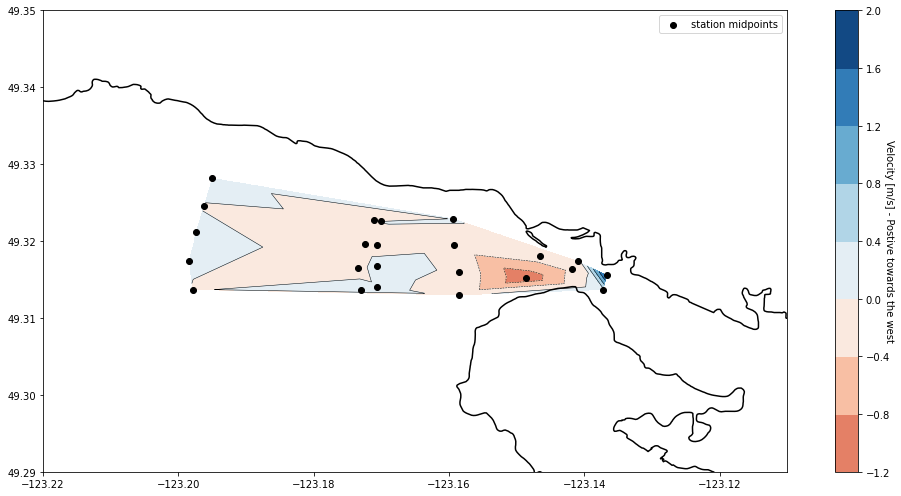

In [45]:
# Create grid values first.
ngridx = 1000
ngridy = 1000
xi = np.linspace(min(surface.lon),max(surface.lon), ngridx)
yi = np.linspace(min(surface.lat),max(surface.lat), ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
zi = griddata((midlon, midlat),Vsur, (xi[None, :], yi[:, None]), method='linear')

fig, ax = plt.subplots(figsize=(14, 7))
plt.contour(xi, yi, zi, linewidths=0.5, colors='k')
plt.contourf(xi, yi, zi, cmap="RdBu", vmin=-2, vmax=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Velocity [m/s] - Postive towards the west', rotation=270)

# #ADD QUIVER plot
# ngridx = 15
# ngridy = 15
# xi = np.linspace(min(surface.lon),max(surface.lon), ngridx)
# yi = np.linspace(min(surface.lat),max(surface.lat), ngridy)

# # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
# zi = griddata((V[1], V[2]),Vsur, (xi[None, :], yi[:, None]), method='linear')
# dx,dy=np.gradient(zi) #gradient doesnt make sense as it amplifies the negative to postive changes
# plt.quiver(xi,yi,dx,dy)

# #ADD drifters
# plt.plot(drift[2].lon,drift[2].lat,'k-',label='Drifter '+str(drift[2].id),zorder=1, linewidth ='2')
# plt.plot(drift[0].lon,drift[0].lat,'k--',label='Drifter '+str(drift[0].id),zorder=1, linewidth ='2')
# plt.plot(drift[1].lon,drift[1].lat,'k-.',label='Drifter '+str(drift[1].id),zorder=1, linewidth ='2')
# plt.scatter([drift[2].lon[0],drift[0].lon[0],drift[1].lon[0]],[drift[2].lat[0],drift[0].lat[0],drift[1].lat[0]],c='b', label='drifter start',zorder=2)
# plt.scatter([drift[2].lon[-1],drift[0].lon[-1],drift[1].lon[-1]],[drift[2].lat[-1],drift[0].lat[-1],drift[1].lat[-1]],c='r', label='drifter end',zorder=2)
# plt.legend()

plt.xlim([-123.22, -123.11])
plt.ylim([49.29,49.35])
#plt.title('DENSITY\nTransect 4')

ax.plot(x, y, 'k')
ax.scatter(midlon, midlat, c='k', label='station midpoints')
ax.set_aspect(5/4.4)
ax.legend()

plt.tight_layout()

plt.savefig('Velocity.png')

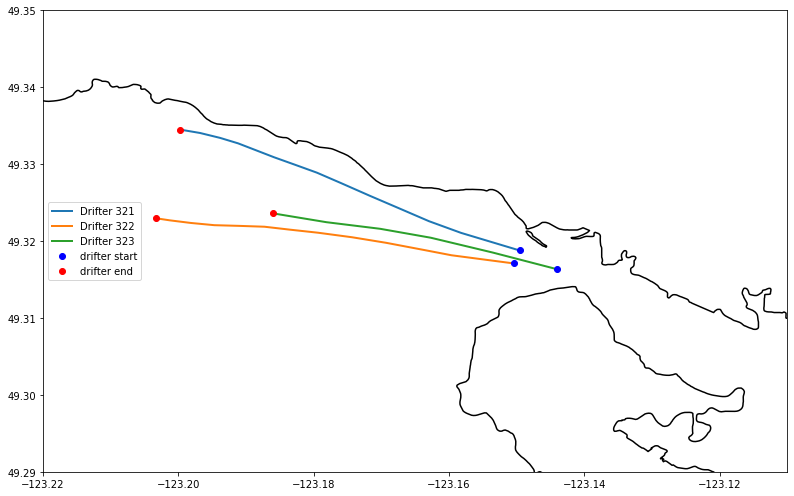

In [46]:
fig, ax = plt.subplots(figsize=(14, 7))

#ADD drifters
plt.plot(drift[2].lon,drift[2].lat,label='Drifter '+str(drift[2].id),zorder=1, linewidth ='2')
plt.plot(drift[0].lon,drift[0].lat,label='Drifter '+str(drift[0].id),zorder=1, linewidth ='2')
plt.plot(drift[1].lon,drift[1].lat,label='Drifter '+str(drift[1].id),zorder=1, linewidth ='2')
plt.scatter([drift[2].lon[0],drift[0].lon[0],drift[1].lon[0]],[drift[2].lat[0],drift[0].lat[0],drift[1].lat[0]],c='b', label='drifter start',zorder=2)
plt.scatter([drift[2].lon[-1],drift[0].lon[-1],drift[1].lon[-1]],[drift[2].lat[-1],drift[0].lat[-1],drift[1].lat[-1]],c='r', label='drifter end',zorder=2)
plt.legend()

plt.xlim([-123.22, -123.11])
plt.ylim([49.29,49.35])
#plt.title('DENSITY\nTransect 4')

ax.plot(x, y, 'k')
# ax.scatter(midlon, midlat, c='k', label='station midpoints')
ax.set_aspect(5/4.4)
ax.legend()
plt.savefig('DrifterTrajectory.png')
plt.tight_layout()